In [77]:
import numpy as np
from numpy.linalg import inv
from scipy.optimize import linprog
import timeit

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (14, 8.27)}, font_scale=2)
sns.set_palette('colorblind')

$min_x f_0(x)$ subject to $f_i(x) \leq 0$ for $i = 1, ..., m$
$f_0(x)$ and $f_i(x)$ are convex and twice differentiable.

$min_x t f_0(x)$ $+$ $e(x)$ for any $t \geq 0$ where $e(x)$ is a log barrier function.

# A)

$min_x$$||Ax-b||_1 = \sum_{i=1}^m |  a_{i} x - b_i |$
$min_x$$||Ax-b||_1 = min_x \sum_{i=1}^m min_{t_i}( -t \leq a_i^Tx - b_i \leq t)$
which is $min_{x,t_i} \sum_{i=1}^m t_1$
with $-t_i \leq a_i^Tx - b_i \leq t_i$ for $i=1,...,m$
This is equivalent to $min_x \tilde{c}^T \tilde{x}$ with constraint $\tilde{A} \tilde{x} \leq \tilde{b}$
Where $$ \tilde{x} =
\left(\begin{array}{cc}
x \\
t
\end{array}\right)
$$
$$ \tilde{c} =
\left(\begin{array}{cc}
0 \\
\textbf{1}
\end{array}\right)
$$
$$ \tilde{A} =
\left(\begin{array}{cc}
A & -\textbf{I}\\
-A & -\textbf{I}
\end{array}\right)
$$
$$ \tilde{b} =
\left(\begin{array}{cc}
b\\
-b
\end{array}\right)
$$

Now we formulate teh problem as $min_x t \tilde{c}^T \tilde{x} - \sum_{i=1}^{2m} log(\tilde{b}_i - \tilde{a}_i^T \tilde{x} )$

this differentiates to $t \tilde{c}^T  + \sum_{i=1}^{2m} \frac{1}{\tilde{b}_i - \tilde{a}_i^T \tilde{x}  } (\tilde{a}_i^T)$

# B)

In [78]:
Ab = []
for i in range(5):
    A = np.genfromtxt('2023-data/A' + str(i) + '.csv', delimiter=",")
    b = np.genfromtxt('2023-data/b' + str(i) + '.csv', delimiter=",")
    Ab.append((A, b))

In [79]:
A, b = Ab[3]

In [80]:
m, n = A.shape
b = b.reshape((m, 1))
c_til = np.zeros((n + m, 1))
c_til[-m:] = 1
b_til = np.vstack((b, -b))
I = np.identity(m)
A_til = np.vstack((np.hstack((A, -I)), np.hstack((-A, -I))))

In [81]:
def f(A, b, c, x, t):
    if (A @ x - b <= 0).all():
        function = t * c.T @ x - np.sum(np.log(b - A @ x))
    else:
        function = 'infeasible'
    return function

In [82]:
def grad_f(x, A, b, c, t):
    grad = t * c + A.T @ (1 / (b - A @ x))
    return grad

In [83]:
def backtracking(x, A, b, c, grad, t, alpha = 0.2, beta= 0.3):
    t_b = 1
    while f(A, b, c, x - t_b * grad, t) == 'infeasible':
        t_b = beta*t_b
    while f(A, b, c, x - t_b * grad, t) > f(A, b, c, x, t) - alpha * t_b * grad.T @ grad:
        t_b = beta * t_b
    x = x - t_b * grad
    return x

In [84]:
opt_x_t = []
x = c_til
costs = []
for t, epsilon in [(1, 0.001), (10, 10), (100, 1000)]:
    iteration = 0
    grad = grad_f(x, A_til, b_til, c_til, t)
    while grad.T @ grad >= epsilon:
        x = backtracking(x, A_til, b_til, c_til, grad, t)
        grad = grad_f(x, A_til, b_til, c_til, t)
        func = f(A_til, b_til, c_til, x, t)
        costs.append(func)
        iteration += 1
        if iteration % 500 == 0:
            print(f'Iteration:{iteration},  func: {func}')
        if iteration % 2000 == 0:
            residual = A @ x[:n] - b
            print(np.sum(np.sqrt(residual*residual)))
            opt_x_t.append(x)

Iteration:500,  func: [[766.6678099]]
Iteration:1000,  func: [[679.2148993]]
Iteration:1500,  func: [[666.05046371]]
Iteration:2000,  func: [[665.38456226]]
318.55396732084984
Iteration:500,  func: [[7405.47969499]]
Iteration:1000,  func: [[7115.90256079]]
Iteration:1500,  func: [[7041.95167822]]
Iteration:2000,  func: [[7014.58387727]]
299.9103602820883
Iteration:2500,  func: [[7001.1405145]]
Iteration:3000,  func: [[6992.91947755]]
Iteration:3500,  func: [[6986.32092677]]
Iteration:4000,  func: [[6982.37702396]]
290.17974359051493
Iteration:4500,  func: [[6980.01576468]]
Iteration:5000,  func: [[6978.01493234]]
Iteration:5500,  func: [[6976.65082146]]
Iteration:6000,  func: [[6975.68991363]]
287.02303131960537
Iteration:6500,  func: [[6975.02133414]]
Iteration:7000,  func: [[6974.54262506]]
Iteration:7500,  func: [[6974.19370265]]
Iteration:500,  func: [[36248.152219]]
Iteration:1000,  func: [[35761.61619013]]
Iteration:1500,  func: [[35566.56194806]]
Iteration:2000,  func: [[35451.6

KeyboardInterrupt: 

In [85]:
residual = A @ opt_x_t[-1][:n] - b
print(np.sum(np.sqrt(residual*residual)))

272.57322203356125


In [86]:
print(c_til.T @ opt_x_t[-1])

[[284.90330822]]


In [87]:
costs = np.asarray(costs)
costs = costs.reshape((costs.shape[0]))

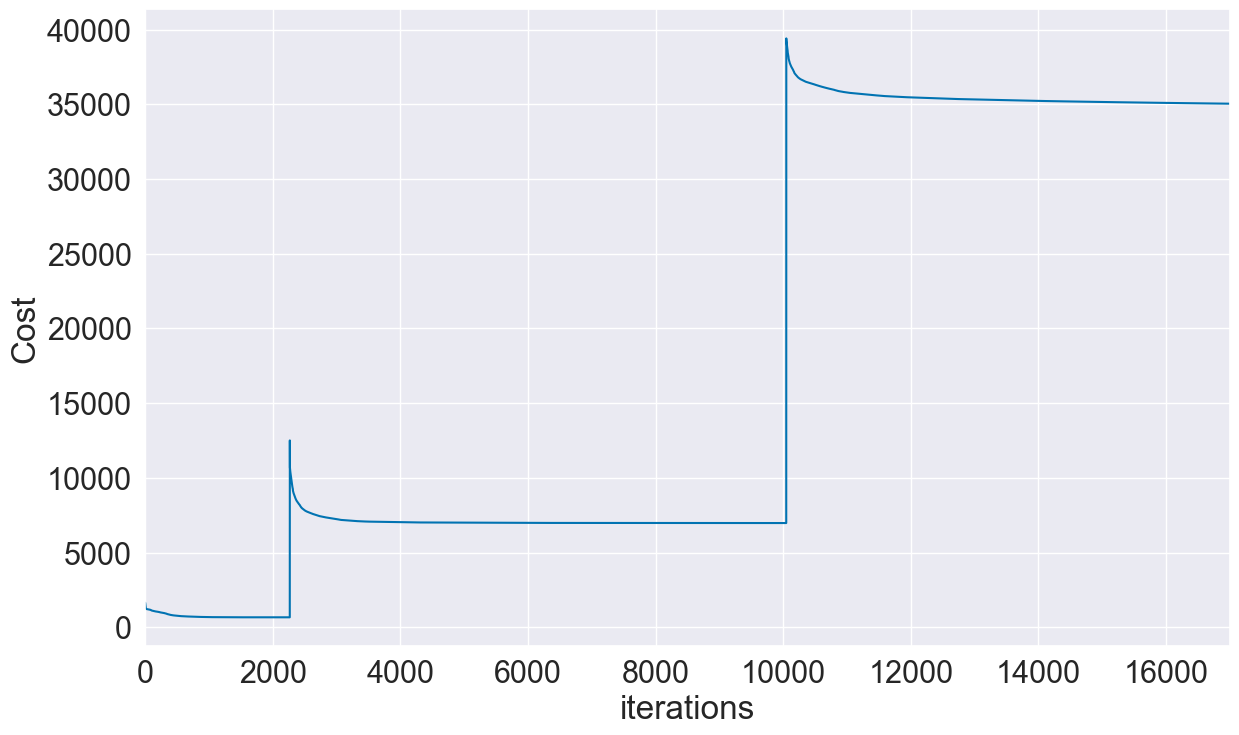

In [96]:
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.xlim(-5, 17000)
plt.savefig('Figures/ex2_costViterations.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close()